In [1]:
import os
import sys
sys.path.append("../bottlenecks")
import configs
from cbm import *
from data_utils import *
from trainer_utils import *
from graph_plot_tools import *
from utils import *
from metric_utils import *
from peft import LoraConfig, get_peft_model
from typing import List, Dict, Optional
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

2024-03-21 08:57:54.200989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 08:57:54.201084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 08:57:54.201124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 08:57:54.209927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 08:57:55.342248: W tensorflow/compiler/

In [3]:
configs.set_seed(42)
device = configs.set_device(4)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [4]:
torch.cuda.get_device_name(device)

'NVIDIA A100-SXM4-80GB'

In [5]:
plt.style.use("seaborn-v0_8")

## settings

In [78]:
import os
import time
import torch
import wandb
import warnings
from graph_plot_tools import *
from cbm import *
from utils import *
from configs import *
from evaluate import load
from IPython import display
from matplotlib import animation
from typing import Optional


def init_history(run_name, nets, opts, displayed_names, bs_muls):
    hist = []
    for net, optimizer, displayed_name, bs_mul in zip(nets, opts, displayed_names, bs_muls):
        hist.append(
            {
                "run_name": run_name,
                "name": displayed_name,
                "bs_mul": bs_mul,
                "train_loss": [],
                "train_x": [],
                "val_loss": [],
                "val_x": [],
                "train_cbl_loss": [],
                "val_cbl_loss": [],
                "train_acc_top_1": [],
                "train_acc_top_5": [],
                "test_acc_top_1": [],
                "test_acc_top_5": [],
                "val_acc_top_1": [],
                "val_acc_top_5": [],
                "val_precision": [],
                "val_recall": [],
                "val_f1": [],
                "test_precision": [],
                "test_recall": [],
                "test_f1": [],
                "norm_diffs": [],
                "epochs_x": [],
                "norm_diffs_x": [],
                "total_steps": 0,
                "prev_val_eval_step": 0,
                "prev_grad_norms_eval_step": 0,
                "batch_end": True,
            }
        )
    return hist 


class CBMConfig:
    def __init__(
        self,
        num_nets: int,
        num_concepts: int,
        num_classes: int,
        run_name: str,
        net_types: list,
        backbones: list,
        displayed_names: list,
        training_methods: list,
        optimizers: list,
        lrs: list,
        cbl_lrs: list,
        train_backbones: list,
        lora_connections: list = [],
    ):
        self.num_nets = num_nets
        self.num_concepts = num_concepts
        self.num_classes = num_classes
        self.run_name = run_name
        self.net_types = net_types
        self.backbones = backbones
        self.displayed_names = displayed_names
        self.training_methods = training_methods
        self.optimizers = optimizers
        self.lrs = lrs
        self.cbl_lrs = cbl_lrs
        self.train_backbones = train_backbones
        self.lora_connections = lora_connections
        self.bs_muls = [1] * self.num_nets
        assert (
            self.num_nets
            == len(self.net_types)
            == len(self.backbones)
            == len(self.training_methods)
            == len(self.optimizers)
            == len(self.lrs)
            == len(self.cbl_lrs)
            == len(self.train_backbones)
            == len(self.bs_muls)
        ), "These lists must be of the same length."
        assert len(self.lora_connections) == len(
            [n for n in self.net_types if n == "lora"]
        ), "LoRA connections must match the number of models with LoRA."
        self.optimizers_dict = {
            "Adam": torch.optim.Adam,
            "AdamW": torch.optim.AdamW,
            "SGD": torch.optim.SGD,
        }

    def _create_models_and_optimizers(self):
        torch.cuda.empty_cache()
        nets, opts = [], []
        lora_cnt = 0
        for _ in range(self.num_nets):
            for net_type, backbone_name, train_backbone, opt_name, lr, cbl_lr in zip(
                self.net_types,
                self.backbones,
                self.train_backbones,
                self.optimizers,
                self.lrs,
                self.cbl_lrs,
            ):
                if net_type == "base":
                    nets.append(
                        BaseCBModel(
                            num_concepts=self.num_concepts,
                            num_classes=self.num_classes,
                            backbone_name=backbone_name,
                            train_backbone=train_backbone,
                        )
                    )
                    nets[-1].zero_grad()
                    nets[-1].train()
                    opts.append(
                        (
                            self.optimizers_dict[opt_name](
                                nets[-1].cbl.parameters(), lr=cbl_lr
                            ),
                            self.optimizers_dict[opt_name](
                                [{"head": nets[-1].head.parameters(),
                                  "params": [p for p in nets[-1].backbone.parameters() if not p.name == "cbl"]}], lr=lr
                                #nets[-1].head.parameters(), lr=lr
                            ),
                        )
                    )
                elif net_type == "lora":
                    nets.append(
                        BaseCBModelWithLora(
                            num_concepts=self.num_concepts,
                            num_classes=self.num_classes,
                            backbone_name=backbone_name,
                            train_backbone=train_backbone,
                            connect_to=self.lora_connections[lora_cnt],
                        )
                    )
                    nets[-1].zero_grad()
                    nets[-1].train()
                    if self.lora_connections[lora_cnt] == "last":
                        opts.append(
                            (
                                self.optimizers_dict[opt_name](
                                    nets[-1].cbl.parameters(), lr=cbl_lr
                                    #[{"params": nets[-1].backbone.visual_projection.parameters(),
                                     #"params": nets[-1].cbl.parameters()}], lr=cbl_lr
                                ),
                                self.optimizers_dict[opt_name](
                                    #nets[-1].head.parameters(), lr=lr
                                    [{"params": nets[-1].backbone.visual_projection.parameters(),
                                     "params": nets[-1].head.parameters()}], lr=lr
                                ),
                            )
                        )
                    #lora count fix
                    #print(lora_cnt, len(self.lora_connections))
                    #lora_cnt += 1
                    #if lora_cnt != len(self.lora_connections):
                    #    lora_cnt += 1
                    #print(lora_cnt, len(self.lora_connections))
                # backbone won't be trained yet, because we connect optimizer only to the head.parameters()
        return nets, opts

    def unpack(self):
        nets, opts = self._create_models_and_optimizers()
        hist = init_history(
            self.run_name, nets, opts, self.displayed_names, self.bs_muls
        )
        return nets, opts, hist, self.run_name, self.training_methods


class BottleneckTrainer:
    def __init__(
        self,
        config,
        train_loader,
        val_loader,
        test_loader,
        num_epochs=10,
        device=None,
        lr_decay=1.0,
        batch_mul_step_count=500,
        norm_diffs_step_count=500,
        val_step_count=500,
        gumbel_hard=False,
        gumbel_tau=1.0,
        l1_lambda=1e-3,
        is_cubed=False,
        report_to=Optional[str],
    ):
        nets, opts, hist, run_name, training_methods = config.unpack()
        self.nets = nets
        self.opts = opts
        self.hist = hist
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = torch.nn.CrossEntropyLoss()
        self.training_methods = training_methods
        self.criterion_gumbel = criterion_gumbel
        self.criterion_contrastive = criterion_contrastive
        self.criterion_l1 = criterion_l1
        self.criterion_similarity = criterion_similarity
        self.precision_metric = load("precision")
        self.recall_metric = load("recall")
        self.f1_metric = load("f1")
        self.lr_decay = lr_decay
        self.run_name = run_name
        self.num_epochs = num_epochs
        self.batch_mul_step_count = batch_mul_step_count
        self.norm_diffs_step_count = norm_diffs_step_count
        self.val_step_count = val_step_count
        self.calc_norm_diffs = False
        self.gumbel_hard = gumbel_hard
        self.gumbel_tau = gumbel_tau
        self.l1_lambda = l1_lambda
        self.is_cubed = is_cubed
        self.report_to = report_to

    def _update_learning_rate(self, param_groups, decay):
        for g in param_groups:
            g["lr"] = g["lr"] * decay

    def train(self):
        num_epochs = self.num_epochs
        batch_mul_step_count = self.batch_mul_step_count
        norm_diffs_step_count = self.norm_diffs_step_count
        val_step_count = self.val_step_count
        calc_norm_diffs = self.calc_norm_diffs

        run_name = self.run_name
        os.makedirs(run_name, exist_ok=True)

        if self.report_to == "wandb":
            run = wandb.init(name=self.run_name, resume=False)

        for epoch in range(num_epochs):
            for net, opt, net_hist, training_method in zip(
                self.nets, self.opts, self.hist, self.training_methods
            ):
                net.to(device)
                bs_mul = net_hist["bs_mul"]
                total_steps = net_hist["total_steps"]

                if net_hist["bs_mul"] == "linear":
                    bs_mul = int(total_steps / batch_mul_step_count) + 1

                net_hist["epochs_x"].append(total_steps)
                optimizer_cbl, optimizer_head = opt

                for i, batch in enumerate(self.train_loader, 0):

                    if (
                        calc_norm_diffs
                        and (
                            (total_steps - net_hist["prev_grad_norms_eval_step"])
                            > norm_diffs_step_count
                            or len(net_hist["norm_diffs"]) == 0
                        )
                        and net_hist["batch_end"]
                    ):
                        net_hist["prev_grad_norms_eval_step"] = total_steps
                        net.eval()

                        norm_diffs = self._compute_norm_diffs(
                            net,
                            optimizer_head,
                            None,
                            train_loader_wo_crops,
                            train_loader_wo_crops,
                            repeats=5,
                        )

                        net_hist["norm_diffs"].append(norm_diffs)
                        net_hist["norm_diffs_x"].append(total_steps)
                        net.train()

                    net_hist["batch_end"] = False

                    self._update_learning_rate(
                        optimizer_head.param_groups, self.lr_decay
                    )

                    inputs, labels = batch
                    inputs, targets = inputs.to(self.device), torch.LongTensor(
                        labels
                    ).to(self.device)
                    cbl_logits, logits = net(**inputs)

                    ########
                    # cbl_mean = torch.mean(cbl_logits)#, dim=0, keepdim=True)
                    # cbl_std = torch.std(cbl_logits)#, dim=0, keepdim=True)
                    # cbl_logits = (cbl_logits - cbl_mean) / cbl_std
                    ########

                    cbl_loss = None  # test this line
                    if training_method == "gumbel":
                        cbl_loss = self.criterion_gumbel(
                            cbl_logits, tau=self.gumbel_tau, hard=self.gumbel_hard
                        )
                    elif training_method == "contrastive":
                        cbl_loss = self.criterion_contrastive(cbl_logits)
                    elif training_method == "l1":
                        cbl_loss = (
                            self.criterion_l1(net, l1_lambda=self.l1_lambda)
                            / cbl_logits.squeeze().shape[1]
                        )
                    elif training_method == "similarity":
                        cbl_loss = -self.criterion_similarity(
                            net.backbone(**inputs).logits_per_image,
                            cbl_logits,
                            self.is_cubed,
                        )

                    cbl_loss.backward(retain_graph=True)
                    ce_loss = self.criterion(logits, targets) / bs_mul
                    ce_loss.backward()

                    if total_steps % bs_mul == bs_mul - 1:
                        optimizer_cbl.step()
                        optimizer_cbl.zero_grad()
                        optimizer_head.step()
                        optimizer_head.zero_grad()
                        net_hist["batch_end"] = True

                    net_hist["train_loss"].append(
                        ce_loss.detach().cpu().item() * bs_mul
                    )
                    net_hist["train_cbl_loss"].append(
                        cbl_loss.detach().cpu().item() * bs_mul
                    )
                    net_hist["train_x"].append(total_steps)

                    if total_steps % bs_mul == bs_mul - 1:
                        if net_hist["bs_mul"] == "linear":
                            net_hist["bs_mul"] = (
                                int(int(total_steps) / batch_mul_step_count) + 1
                            )
                            bs_mul = net_hist["bs_mul"]

                    top_1, top_5 = self._accuracy(logits, targets, topk=(1, 5))
                    net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
                    net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

                    prev_val_eval_step = net_hist["prev_val_eval_step"]
                    if (total_steps - prev_val_eval_step) > val_step_count and net_hist[
                        "batch_end"
                    ]:
                        net_hist["prev_val_eval_step"] = total_steps

                        net.eval()

                        (
                            val_cbl_losses,
                            val_ce_losses,
                            val_top_1_accs,
                            val_top_5_accs,
                            val_top_1_precisions,
                            val_top_1_recalls,
                            val_top_1_f1scores,
                        ) = self._evaluate(net, self.val_loader, training_method)

                        net_hist["val_loss"].append(np.mean(val_ce_losses))
                        net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                        net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                        net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))

                        net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                        net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                        net_hist["val_f1"].append(np.mean(val_top_1_f1scores))

                        net_hist["val_x"].append(total_steps)
                        net.train()

                    if total_steps % 10 == 0:
                        start_time = time.time()
                        self._display_results(net_hist)

                    total_steps += 1

                    net_hist["total_steps"] = total_steps
                 
                if (net_hist["total_steps"] - net_hist["prev_val_eval_step"]) > val_step_count and net_hist["batch_end"]:
                    self.save_checkpoint(
                        epoch, net, optimizer_cbl, optimizer_head, net_hist
                    )
            if self.report_to == "wandb": 
                run.log({
                    "train loss":  net_hist["train_loss"],
                    "train cbl loss": net_hist["train_cbl_loss"],
                    "train accuracy top 1": net_hist["train_acc_top_1"],
                    "train accuracy top 5": net_hist["train_acc_top_5"],
                    "val loss": net_hist["val_loss"],
                    "val cbl loss": net_hist["val_cbl_loss"],
                    "val accuracy top 1": net_hist["val_acc_top_1"],
                    "val accuracy top 5": net_hist["val_acc_top_5"],
                    "val precision": net_hist["val_precision"],
                    "val recall": net_hist["val_recall"],
                    "val f1": net_hist["val_f1"],
                })
        print("Finished Training")

    def save_checkpoint(self, epoch, net, optimizer_cbl, optimizer_head, net_hist):
        state_dict = {
            "epoch": epoch,
            str(net_hist["val_acc_top_1"][-1])[:5]
            + "_model_state_dict": net.state_dict(),
            "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
            "optimizer_head_state_dict": optimizer_head.state_dict(),
            "loss_train": net_hist["train_loss"],
            "cbl_loss_train": net_hist["train_cbl_loss"],
            "loss_val": net_hist["val_loss"],
            "cbl_loss_val": net_hist["val_cbl_loss"],
        }
        torch.save(
            state_dict,
            os.path.join(
                self.run_name,
                str(net_hist["val_acc_top_1"][-1])[:5]
                + f"_checkpoint_{epoch}_epoch.pth",
            ),
        )

    def _compute_norm_diffs(
        self, net, optimizer, scheduler, train_loader, valid_loader, repeats
    ):
        pass

    def _accuracy(self, output, target, topk=(1,)):
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

    @torch.no_grad()
    def _evaluate(self, net, loader, training_method):
        cbl_losses, ce_losses = [], []
        top_1_accs, top_5_accs = [], []
        top_1_precisions, top_1_recalls = [], []
        top_1_f1scores = []

        with torch.no_grad():
            for step, batch in enumerate(loader, 0):
                warnings.filterwarnings("ignore")
                inputs, labels = batch
                inputs, targets = inputs.to(self.device), torch.LongTensor(labels).to(
                    self.device
                )
                cbl_logits, logits = net(**inputs)

                ########
                # cbl_mean = torch.mean(cbl_logits)#, dim=0, keepdim=True)
                # cbl_std = torch.std(cbl_logits)#, dim=0, keepdim=True)
                # cbl_logits = (cbl_logits - cbl_mean) / cbl_std
                ########

                if training_method == "gumbel":
                    cbl_loss = self.criterion_gumbel(
                        cbl_logits, tau=self.gumbel_tau, hard=self.gumbel_hard
                    )
                elif training_method == "contrastive":
                    cbl_loss = self.criterion_contrastive(cbl_logits)
                elif training_method == "l1":
                    cbl_loss = (
                        self.criterion_l1(net, l1_lambda=self.l1_lambda)
                        / cbl_logits.squeeze().shape[1]
                    )
                elif training_method == "similarity":
                    cbl_loss = -self.criterion_similarity(
                        net.backbone(**inputs).logits_per_image,
                        cbl_logits,
                        self.is_cubed,
                    )

                cbl_losses.append(cbl_loss.detach().cpu().item())

                ce_loss = self.criterion(logits, targets)
                ce_losses.append(ce_loss.detach().cpu().item())

                top_1, top_5 = self._accuracy(logits, targets, topk=(1, 5))
                top_1_accs.append(top_1.detach().cpu().item())
                top_5_accs.append(top_5.detach().cpu().item())

                precs = self.precision_metric.compute(
                    predictions=logits.argmax(dim=-1).cpu(),
                    references=targets.cpu(),
                    average="weighted",
                )
                recs = self.recall_metric.compute(
                    predictions=logits.argmax(dim=-1).cpu(),
                    references=targets.cpu(),
                    average="weighted",
                )
                f1 = self.f1_metric.compute(
                    predictions=logits.argmax(dim=-1).cpu(),
                    references=targets.cpu(),
                    average="weighted",
                    labels=np.unique(logits.argmax(dim=-1).cpu()),
                )

                top_1_precisions.append(precs["precision"])
                top_1_recalls.append(recs["recall"])
                top_1_f1scores.append(f1["f1"])

        return (
            cbl_losses,
            ce_losses,
            top_1_accs,
            top_5_accs,
            top_1_precisions,
            top_1_recalls,
            top_1_f1scores,
        )

    @torch.no_grad()
    def test(self):
        if self.test_loader is None:
            print("No test loader is provided!", "\n")
        else:
            print("Begin Testing")
            for net, opt, net_hist, training_method in tqdm(
                zip(self.nets, self.opts, self.hist, self.training_methods)
            ):
                net.to(self.device)
                net.eval()
                (
                    test_cbl_losses,
                    test_ce_losses,
                    test_top_1_accs,
                    test_top_5_accs,
                    test_top_1_precisions,
                    test_top_1_recalls,
                    test_top_1_f1scores,
                ) = self._evaluate(net, self.test_loader, training_method)

                net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
                net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))

                net_hist["test_precision"].append(np.mean(test_top_1_precisions))
                net_hist["test_recall"].append(np.mean(test_top_1_recalls))
                net_hist["test_f1"].append(np.mean(test_top_1_f1scores))

                torch.save(
                    {
                        str(net_hist["test_acc_top_1"][-1])[:5]
                        + "_model.bin": net.state_dict
                    },
                    os.path.join(
                        self.run_name,
                        str(net_hist["test_acc_top_1"][-1])[:5] + "_model.bin",
                    ),
                )
                print(net_hist["test_acc_top_1"][-1], "\n")
            print("Finished Testing")
    
    def _display_results(self, net_hist, wait=True, clear_output=True):
        if clear_output:
            display.clear_output(wait=wait)

        grouped_hist = group_uniques_full(
            self.hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"]
        )

        fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
        gs = GridSpec(
            4 + 2 * ((len(grouped_hist) + 2) // 3),
            3,
            figure=fig,
            wspace=0.3,
            hspace=0.9,
        )
        ax1 = fig.add_subplot(gs[0:4, :2])
        ax2 = fig.add_subplot(gs[0:2, 2])
        ax3 = fig.add_subplot(gs[2:4, 2])
        make_loss_plot(
            ax1, grouped_hist, loss_name="CE Loss", eps=0.01, make_val=True, alpha=0.9
        )
        make_accuracy_plot(
            ax2,
            grouped_hist,
            eps=0.01,
            make_train=True,
            make_val=False,
            top_k=1,
            alpha=0.9,
        )
        make_accuracy_plot(
            ax3,
            grouped_hist,
            eps=0.01,
            make_train=False,
            make_val=True,
            top_k=1,
            alpha=0.9,
        )
        plt.draw()

        def animate(frame):
            row = frame // 3
            col = frame % 3
            if col == 0:
                ax1 = make_loss_plot(
                    ax1,
                    grouped_hist,
                    loss_name="CE Loss",
                    eps=0.01,
                    make_val=True,
                    alpha=0.9,
                )
            elif col == 1:
                ax2 = make_accuracy_plot(
                    ax2,
                    grouped_hist,
                    eps=0.01,
                    make_train=True,
                    make_val=False,
                    top_k=1,
                    alpha=0.9,
                )
            elif col == 2:
                ax3 = make_accuracy_plot(
                    ax3,
                    grouped_hist,
                    eps=0.01,
                    make_train=False,
                    make_val=True,
                    top_k=1,
                    alpha=0.9,
                )

            plt.draw()

        if net_hist["epochs_x"] == self.num_epochs - 1:
            savepath = os.path.join(self.run_name, "training_plots.png")
            fig.savefig(savepath, dpi=300)

        frames = len(grouped_hist) * 3
        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames=frames, interval=1000, blit=False
        )
        plt.show(block=True)

## experiments

In [6]:
with open("../data/cub_filtered.txt", "r") as f:
    concepts = f.read().split('\n')

In [38]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_base_link,
                                                 )

  0%|          | 0/74 [00:00<?, ?it/s]

In [39]:
val_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                               concepts=concepts,
                                               prep_loaders="val",
                                               batch_size=128,
                                               backbone_name=Constants.clip_base_link,
                                              )

  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
test_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                                concepts=concepts,
                                                prep_loaders="test",
                                                batch_size=128,
                                                backbone_name=Constants.siglip_so_link,
                                               )

  0%|          | 0/10 [00:00<?, ?it/s]

In [146]:
config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="new_trainer_test",
    net_types=["base", "base"],
    backbones=[Constants.clip_base_link, Constants.clip_base_link],
    displayed_names=["Base, gumbel, 3e-4", "Base, similarity, 3e-4"],
    training_methods=["gumbel", "similarity"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=[],
)

In [172]:
trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device,
    #report_to="wandb",
)

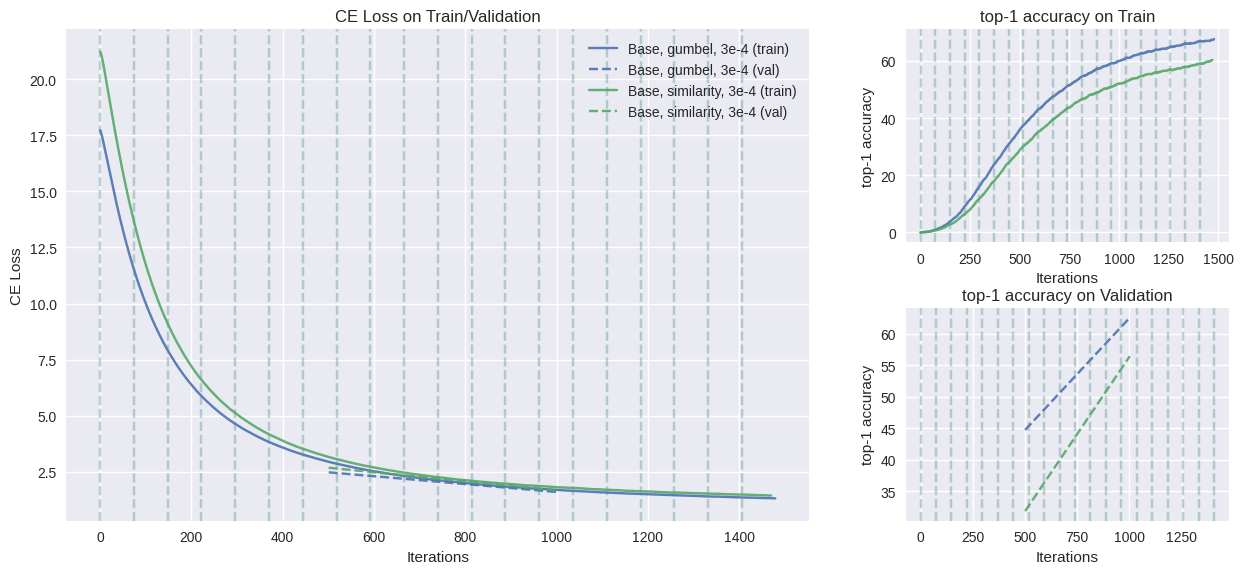

Finished Training


In [162]:
trainer.train()

###  **SigLIP test**

In [196]:
siglip_config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="new_trainer_test",
    net_types=["base", "base"],
    backbones=[Constants.siglip_so_link, Constants.siglip_so_link],
    displayed_names=["Siglip, gumbel, 3e-4", "Siglip, similarity, 3e-4"],
    training_methods=["gumbel", "similarity"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=[],
)

In [ ]:
siglip_trainer = BottleneckTrainer(
    siglip_config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device,
    #report_to="wandb",
)

### **AltCLIP test**

In [7]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.altclip_link,
                                                 )

  0%|          | 0/74 [00:00<?, ?it/s]

In [8]:
val_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                               concepts=concepts,
                                               prep_loaders="val",
                                               batch_size=128,
                                               backbone_name=Constants.altclip_link,
                                              )

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
test_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                                concepts=concepts,
                                                prep_loaders="test",
                                                batch_size=128,
                                                backbone_name=Constants.altclip_link,
                                               )

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
torch.cuda.empty_cache()

In [10]:
altclip_config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="altclip_runs",
    net_types=["base", "base"],
    backbones=[Constants.altclip_link, Constants.altclip_link],
    displayed_names=["AltCLIP, gumbel, 3e-4", "AltCLIP, similarity, 3e-4"],
    training_methods=["gumbel", "similarity"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=[],
)

In [11]:
altclip_trainer = BottleneckTrainer(
    altclip_config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device,
    #report_to="wandb",
)

/home/andreisemenov/anaconda3/envs/andronserv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


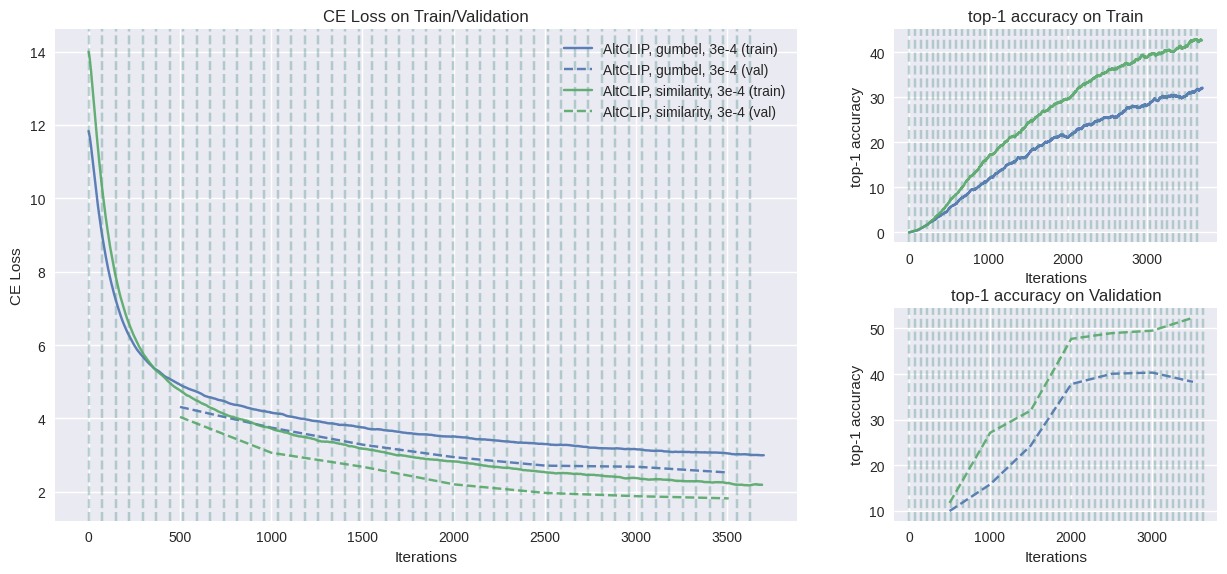

Finished Training


In [17]:
altclip_trainer.train()

In [19]:
altclip_trainer.test()

Begin Testing


0it [00:00, ?it/s]

43.05844917297363 

53.307291412353514 

Finished Testing


In [60]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs_2, targets = inputs_2.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = altclip_trainer.nets[0](**inputs_2)
        break

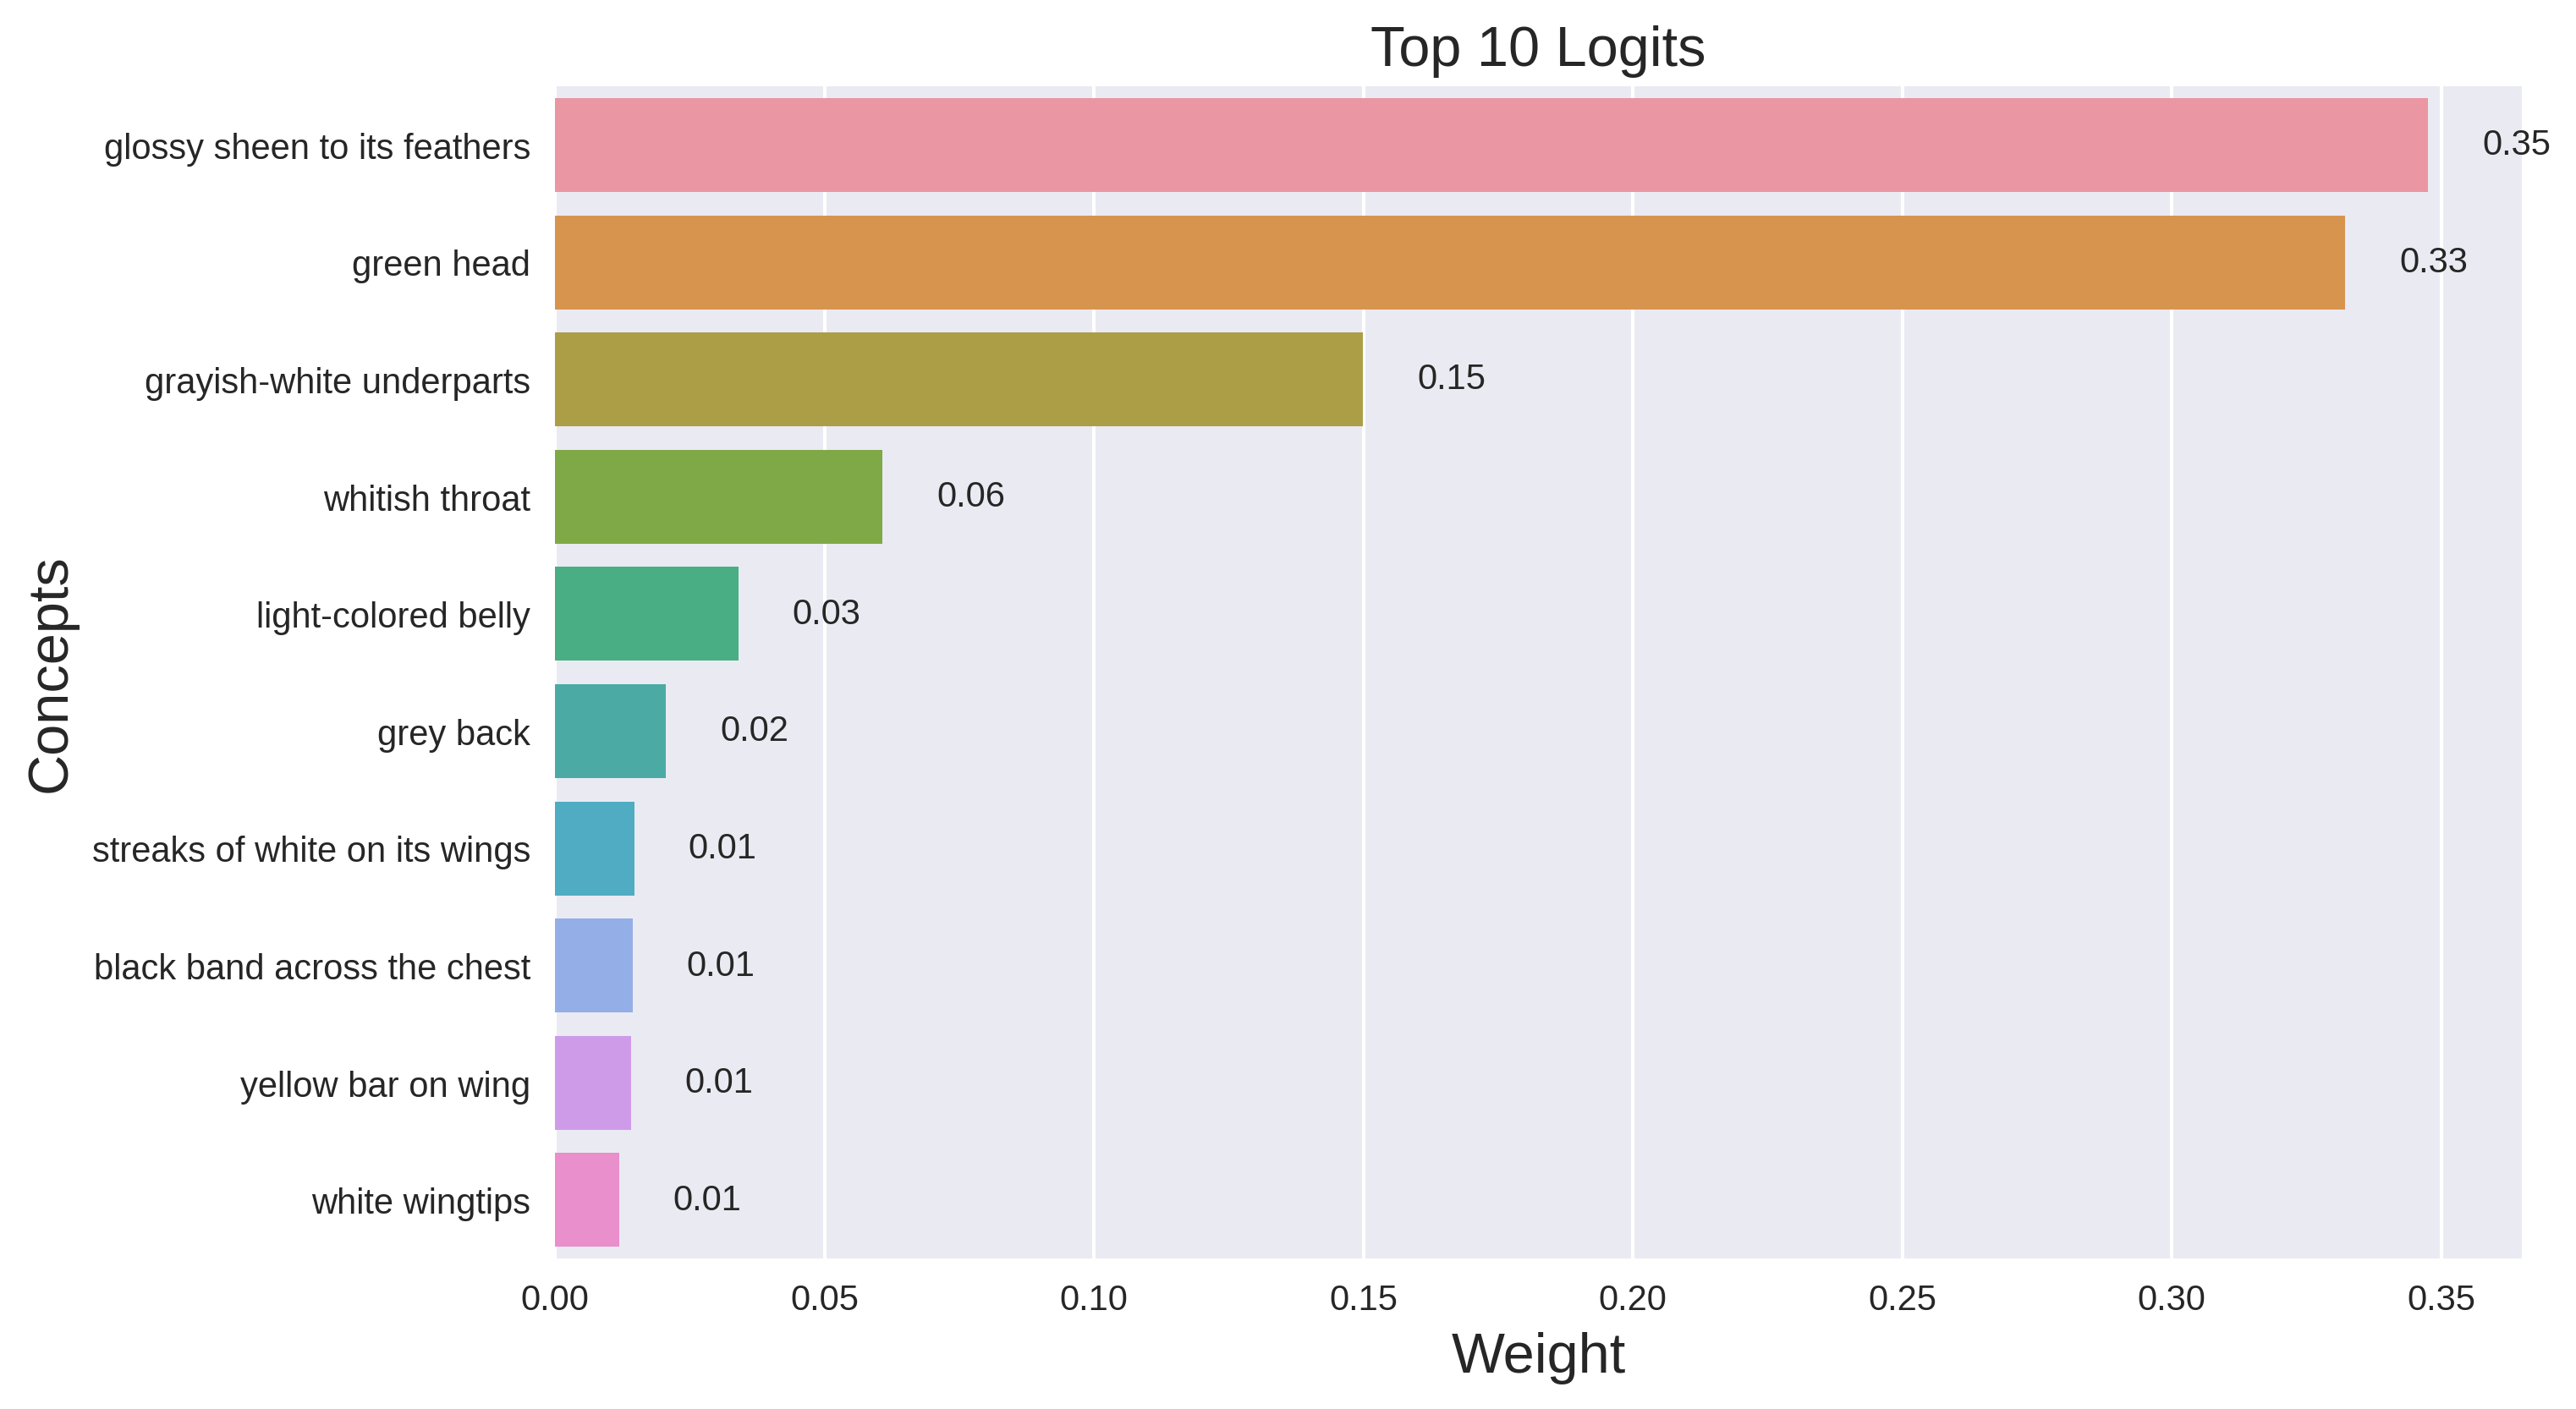

In [61]:
"""Gumbel"""
draw_bottleneck(image_2, cbl_logits, k=10, concepts=concepts, draw_probs=True) 

In [62]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs_2, targets = inputs_2.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = altclip_trainer.nets[1](**inputs_2)
        break

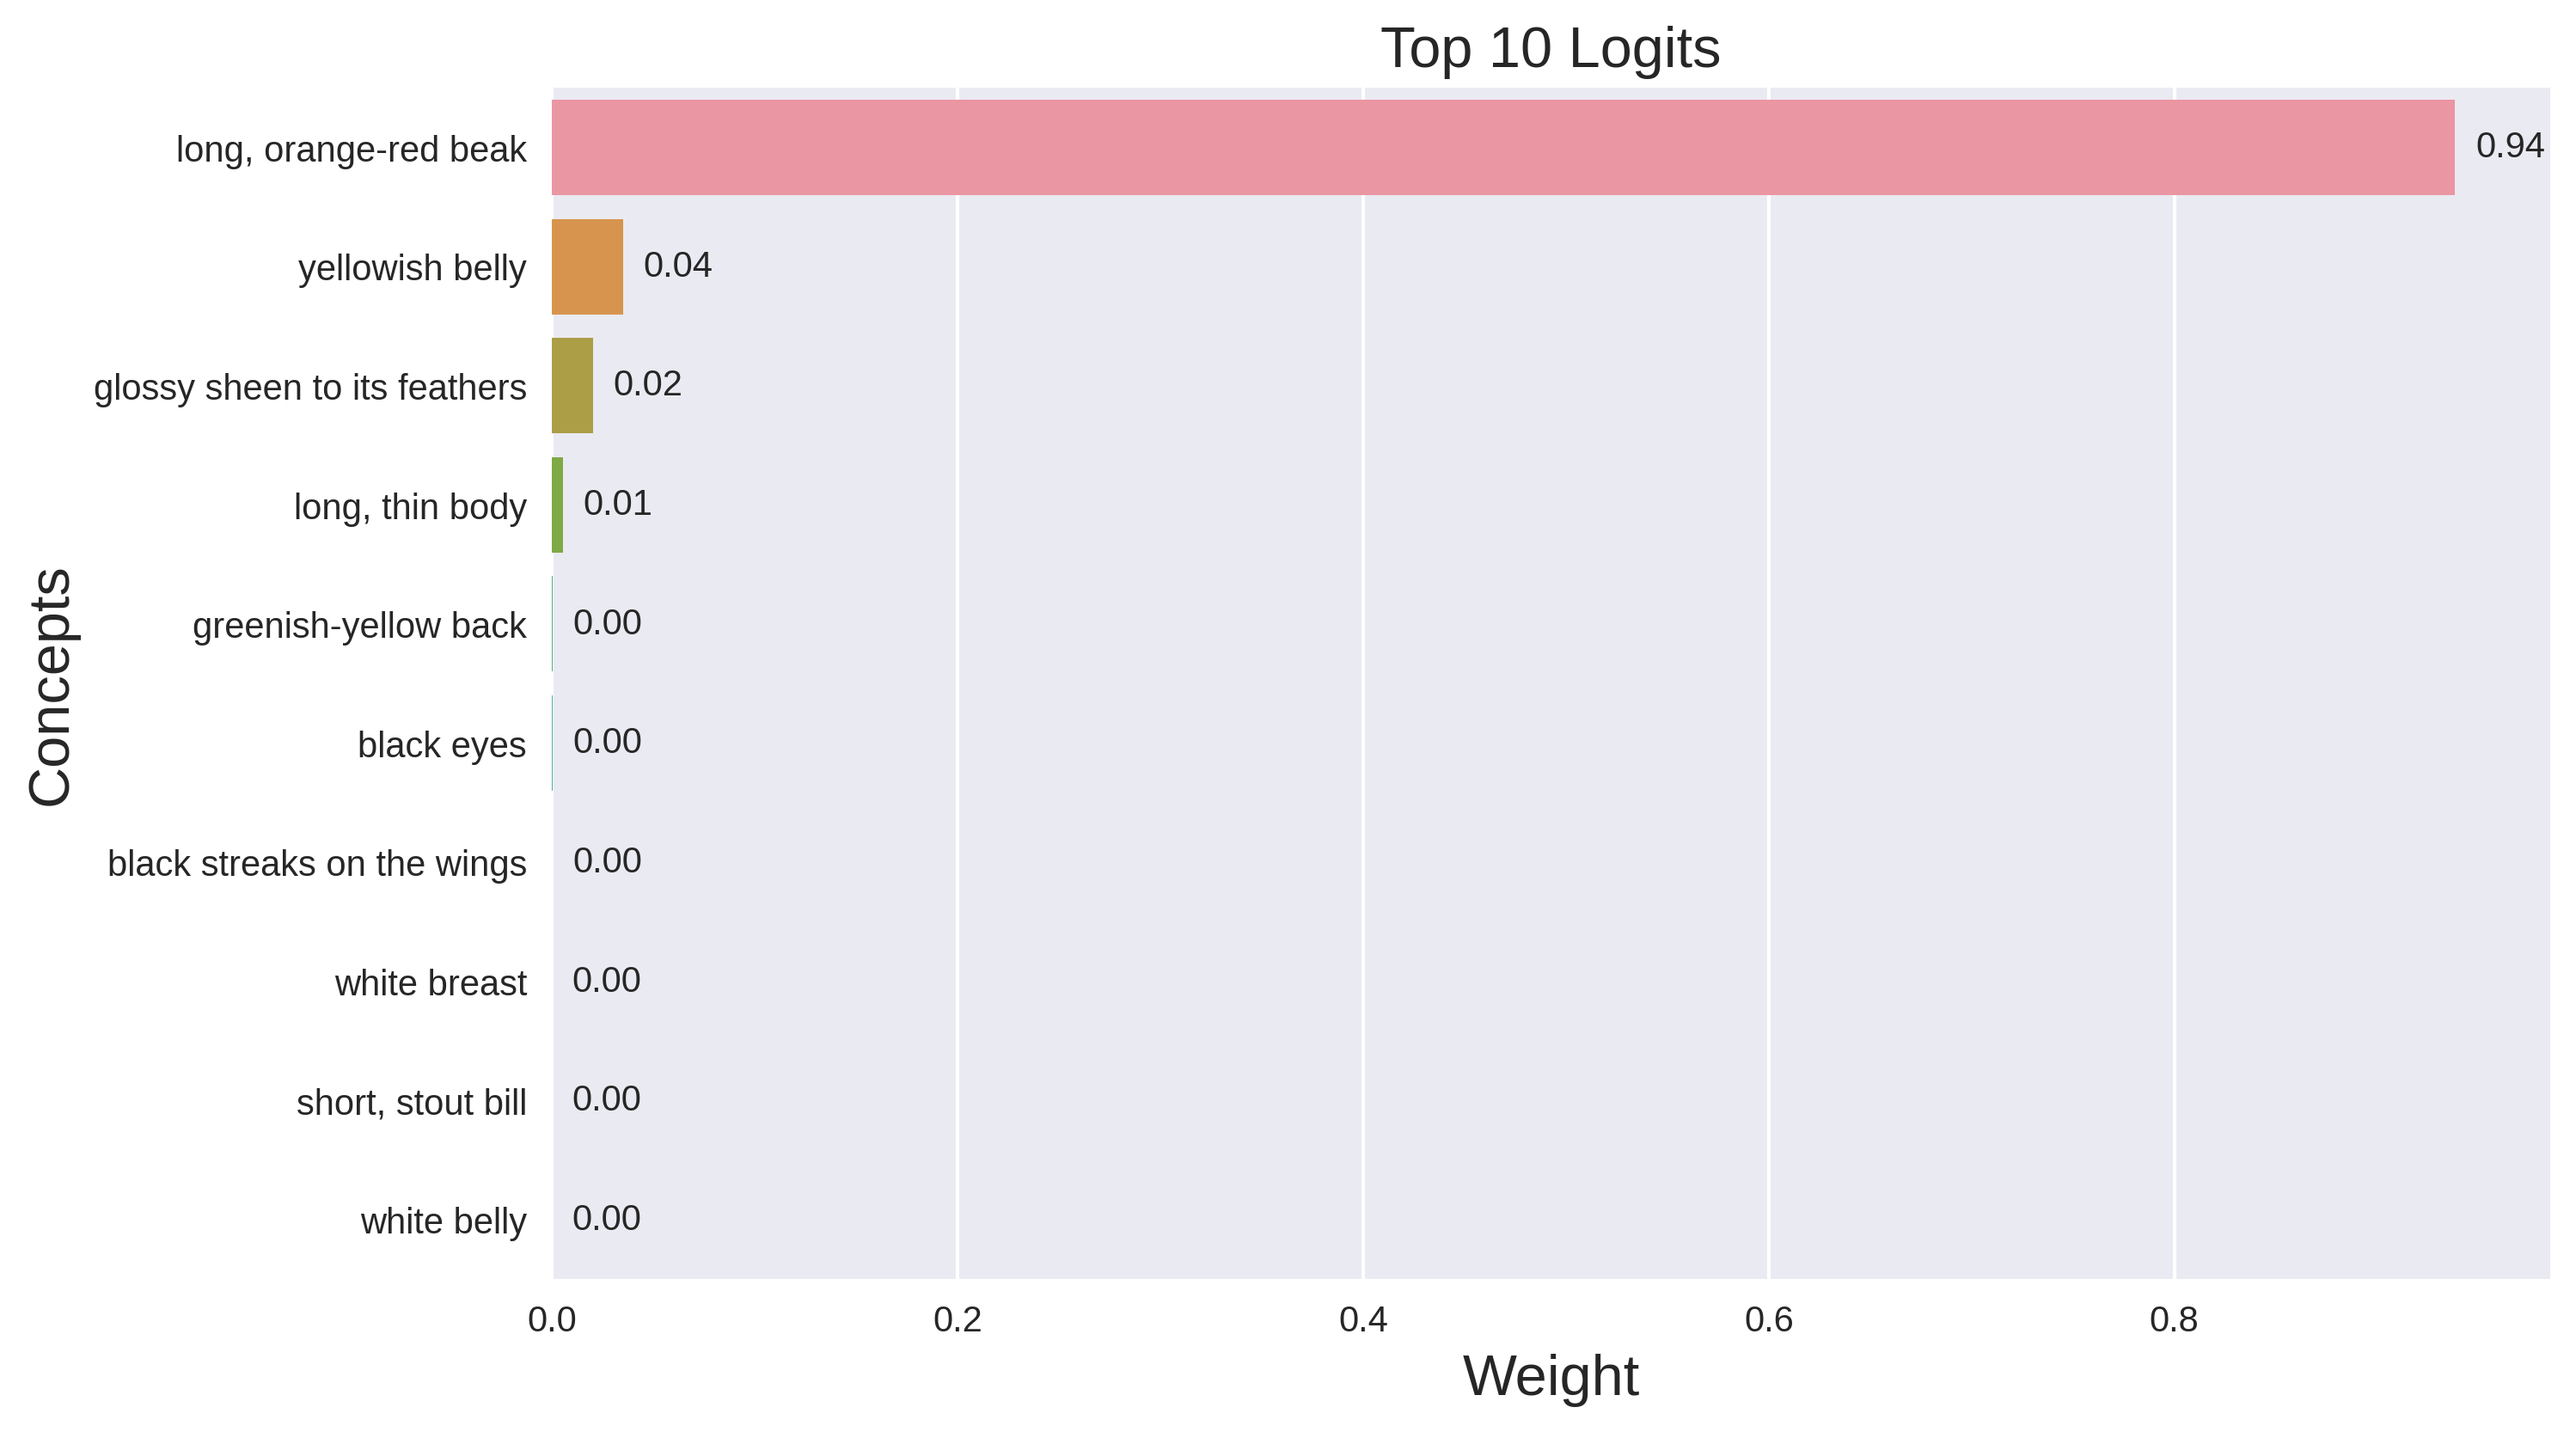

In [63]:
"""Similarity"""
draw_bottleneck(image_2, cbl_logits, k=10, concepts=concepts, draw_probs=True) 

In [20]:
altclip_config2 = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="altclip_runs",
    net_types=["base", "base"],
    backbones=[Constants.altclip_link, Constants.altclip_link],
    displayed_names=["AltCLIP, contrastive, 3e-4", "AltCLIP, l1, 3e-4"],
    training_methods=["contrastive", "l1"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=[],
)

In [21]:
altclip_trainer2 = BottleneckTrainer(
    altclip_config2,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device,
    #report_to="wandb",
)

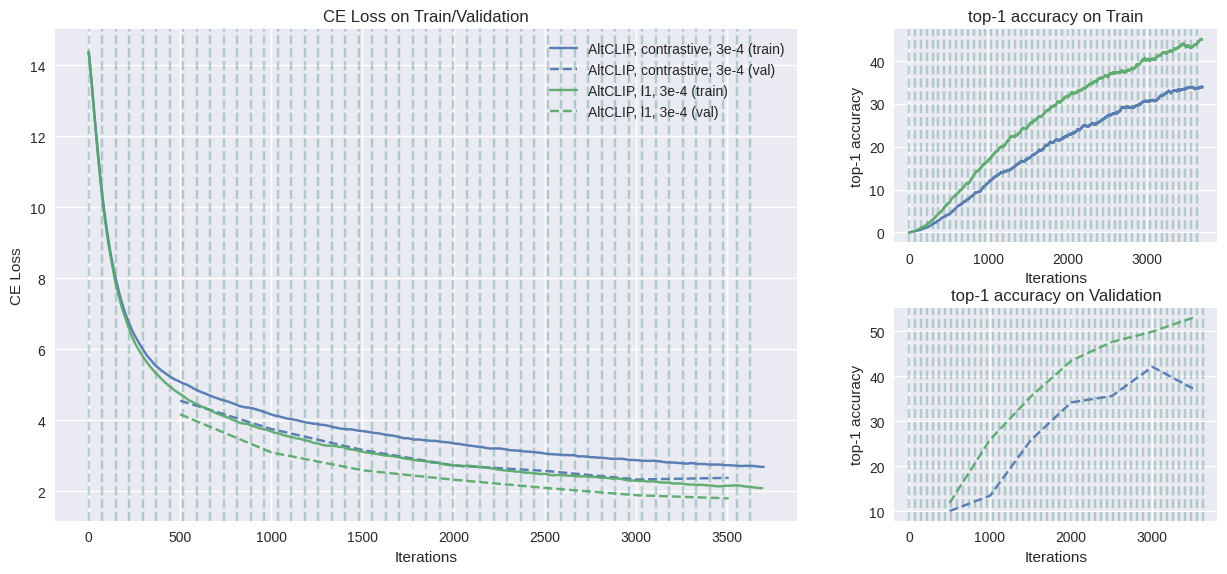

Finished Training


In [26]:
altclip_trainer2.train()

In [28]:
processor = altclip_trainer2.nets[0].processor

In [30]:
import PIL
image_2 = PIL.Image.open('image-2.jpg')
inputs_2 = processor(text=concepts, images=image_2, return_tensors="pt", padding=True)

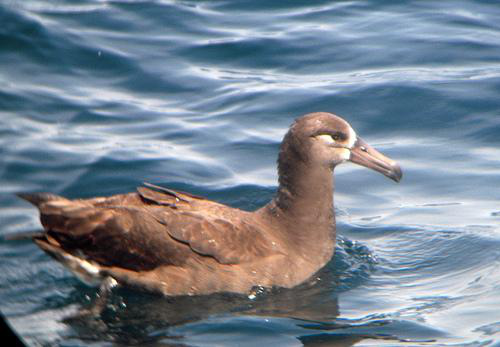

In [31]:
image_2

In [34]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs_2, targets = inputs_2.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = altclip_trainer2.nets[0](**inputs_2)
        break

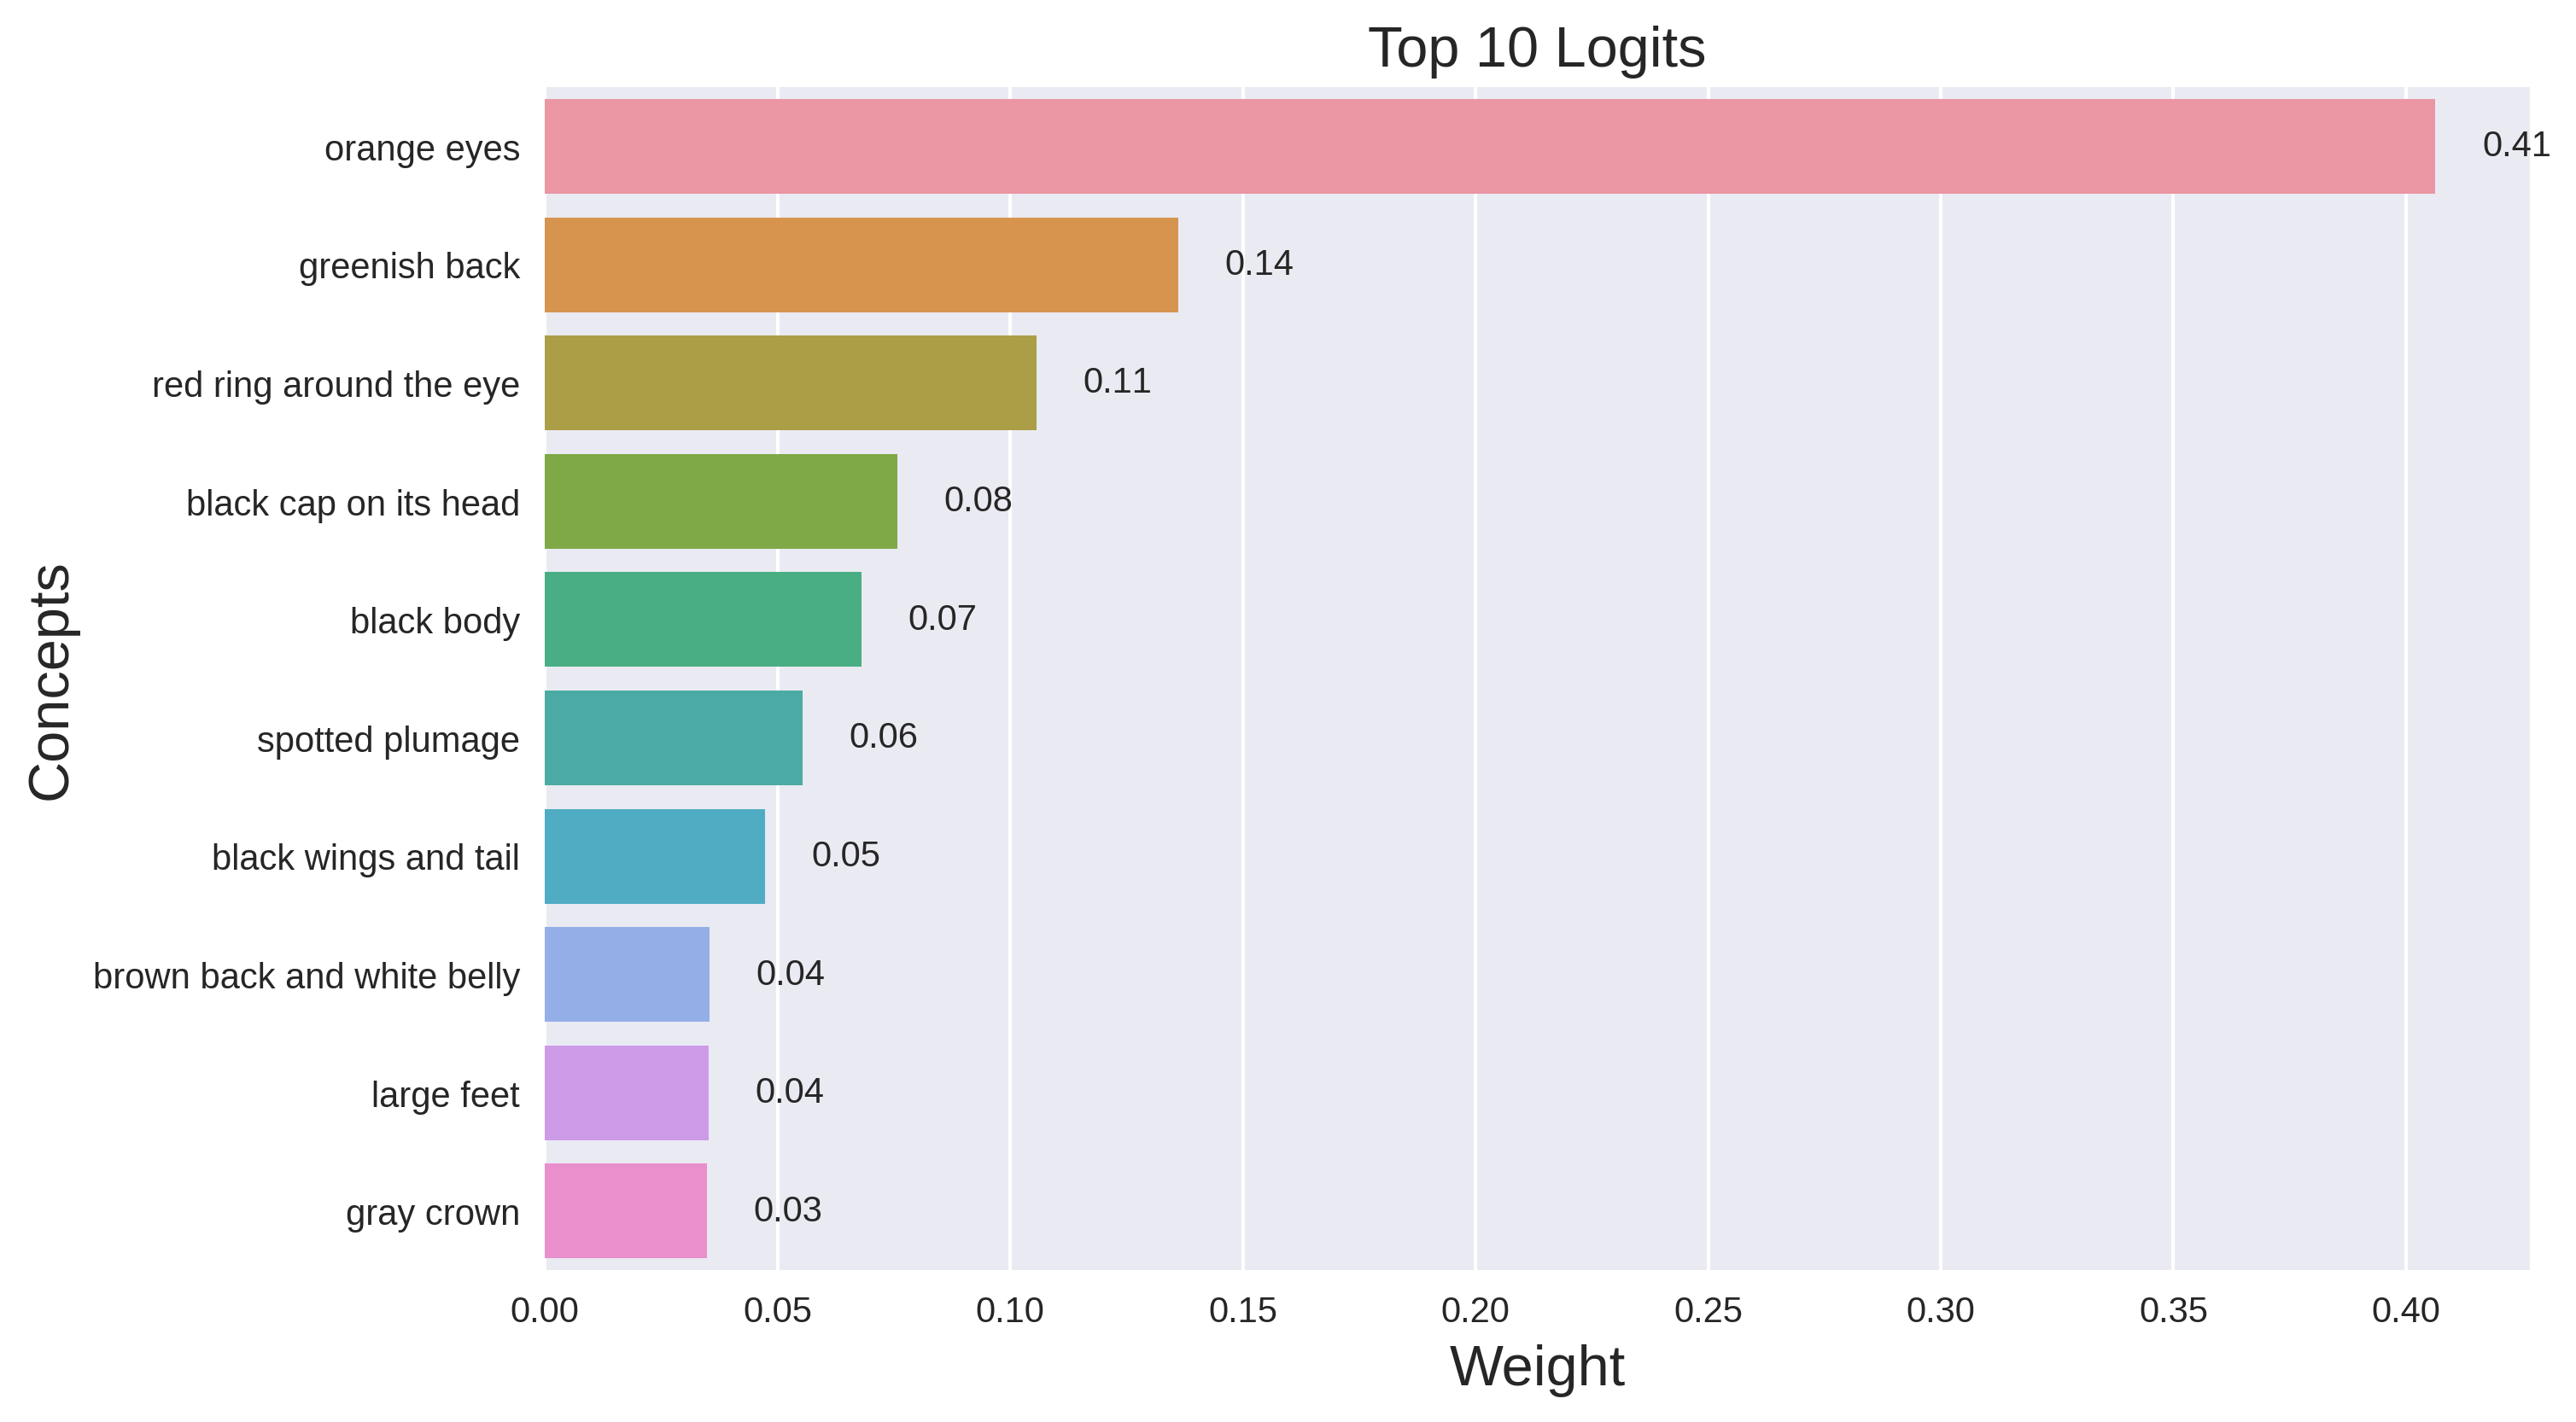

In [35]:
"""Contrastive"""
draw_bottleneck(image_2, cbl_logits, k=10, concepts=concepts, draw_probs=True) 

In [36]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs_2, targets = inputs_2.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = altclip_trainer2.nets[1](**inputs_2)
        break

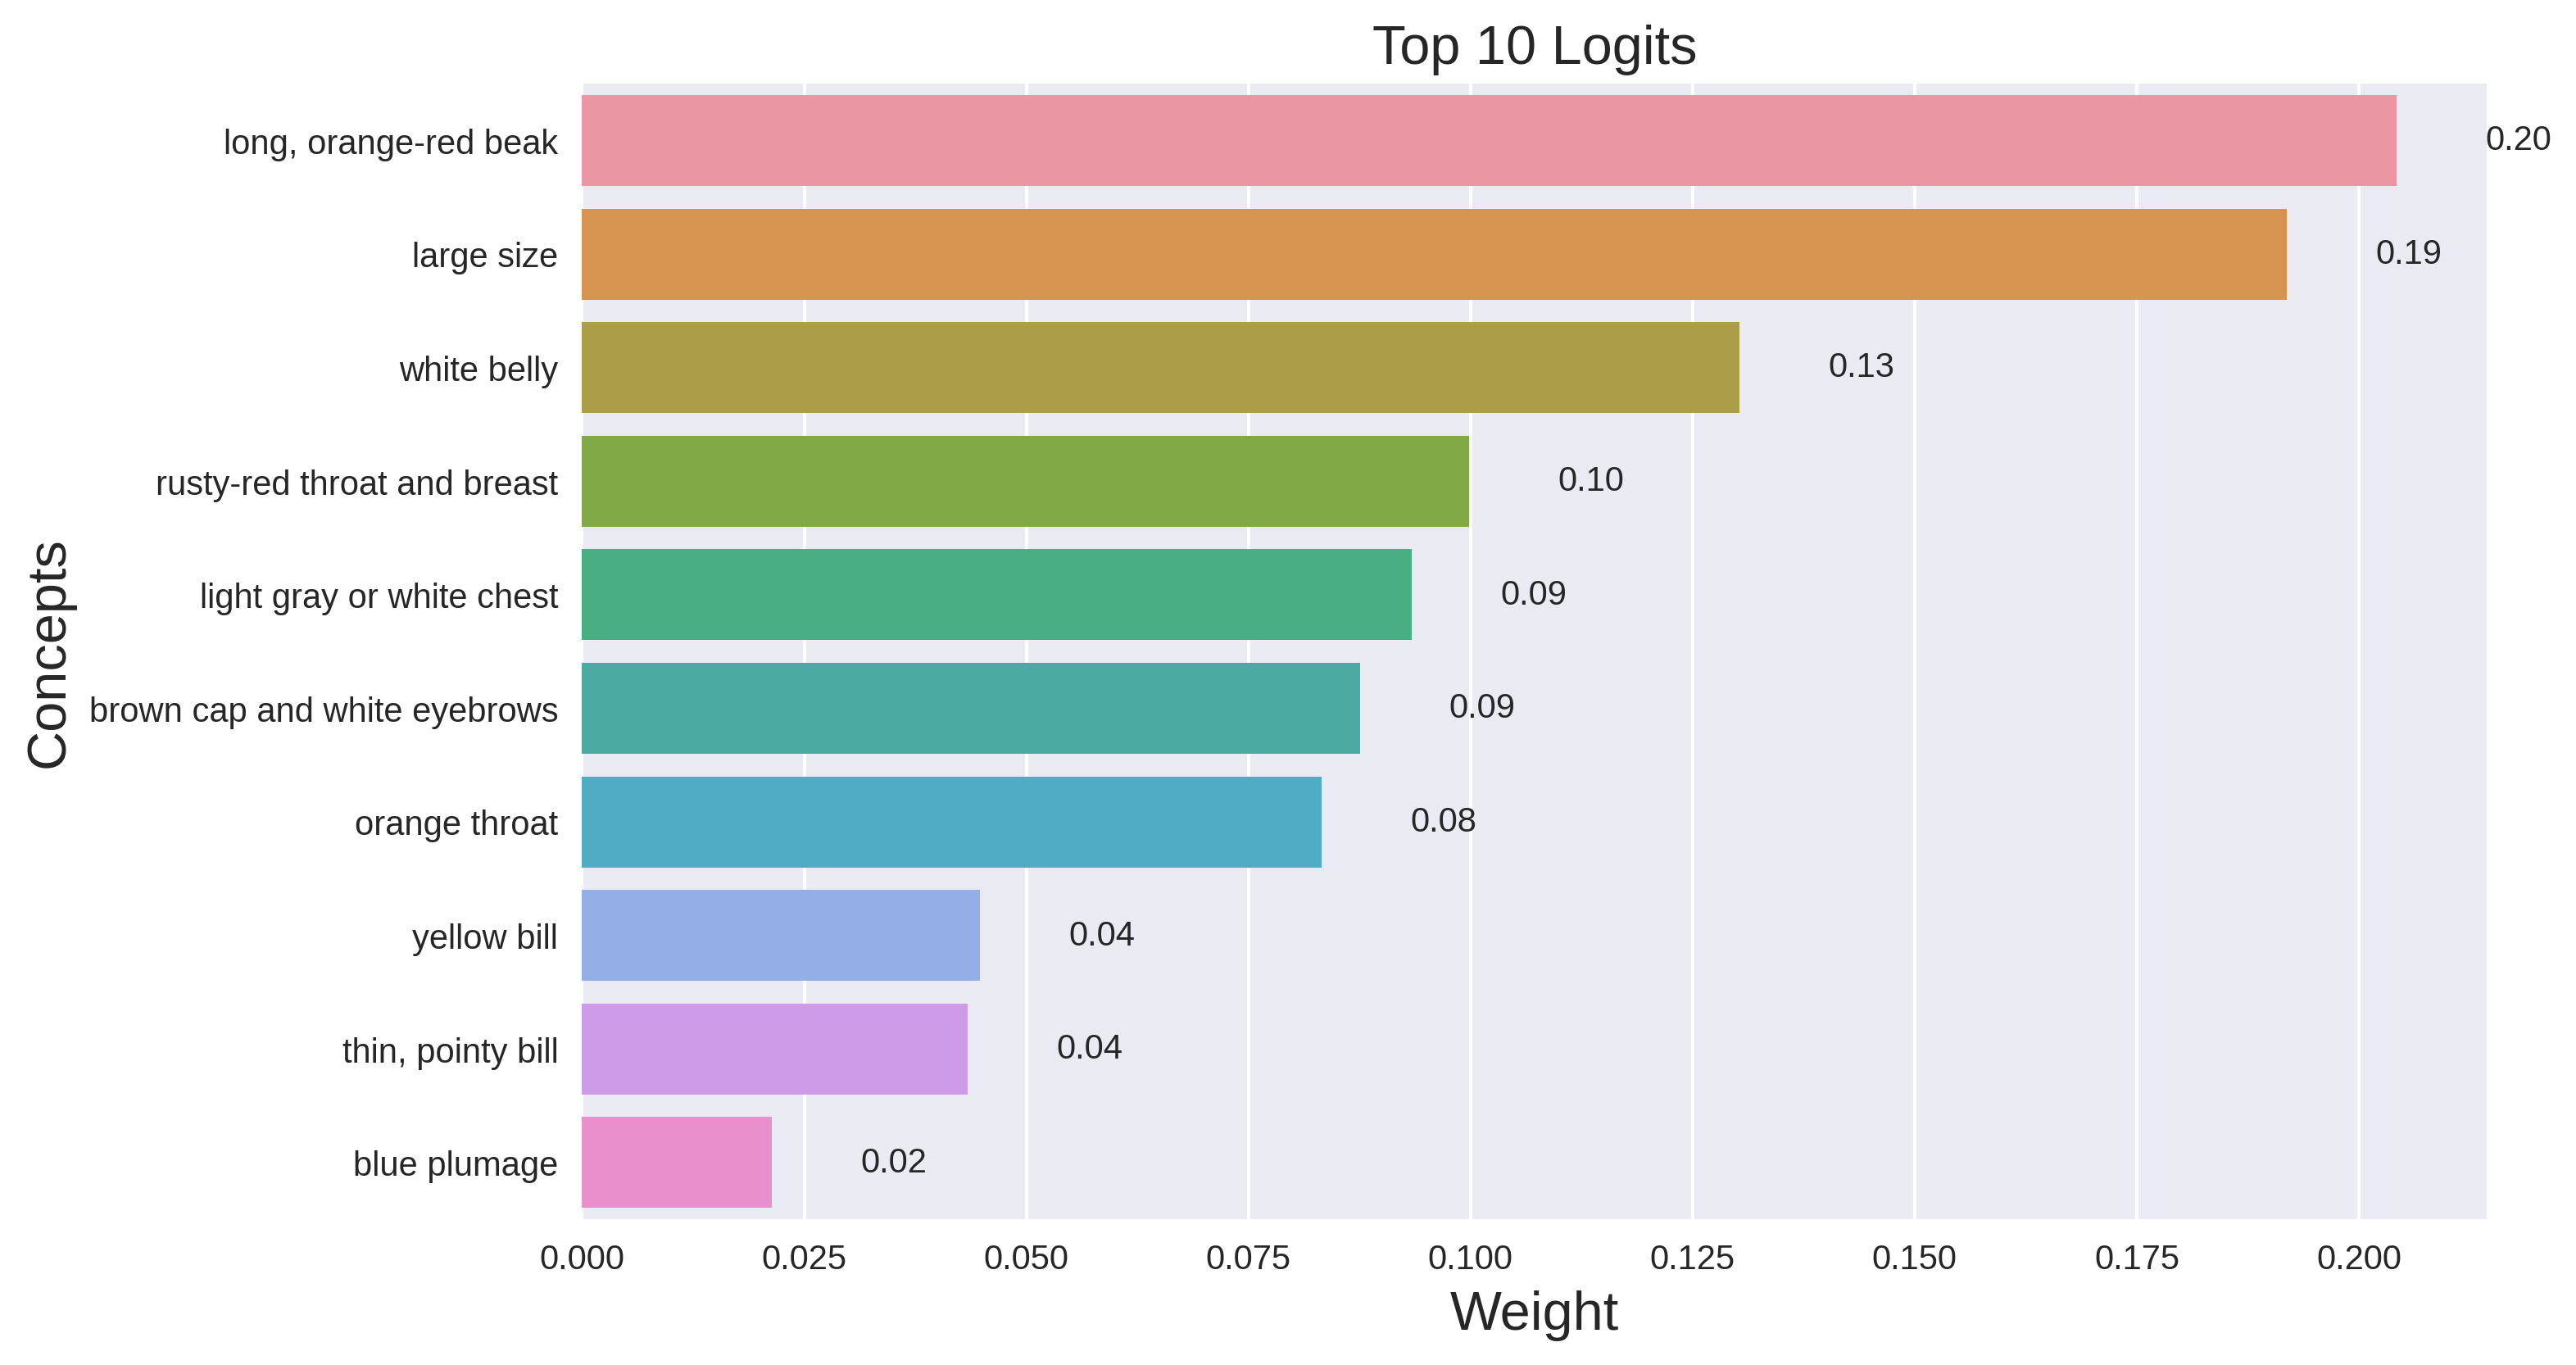

In [37]:
"""L1"""
draw_bottleneck(image_2, cbl_logits, k=10, concepts=concepts, draw_probs=True)

In [39]:
with torch.no_grad():
    inputs = processor(text=concepts, images=image_2, return_tensors="pt", padding=True).to(device)
    logits_per_image = altclip_trainer2.nets[0].backbone(**inputs).logits_per_image
    probs = logits_per_image.softmax(dim=1)

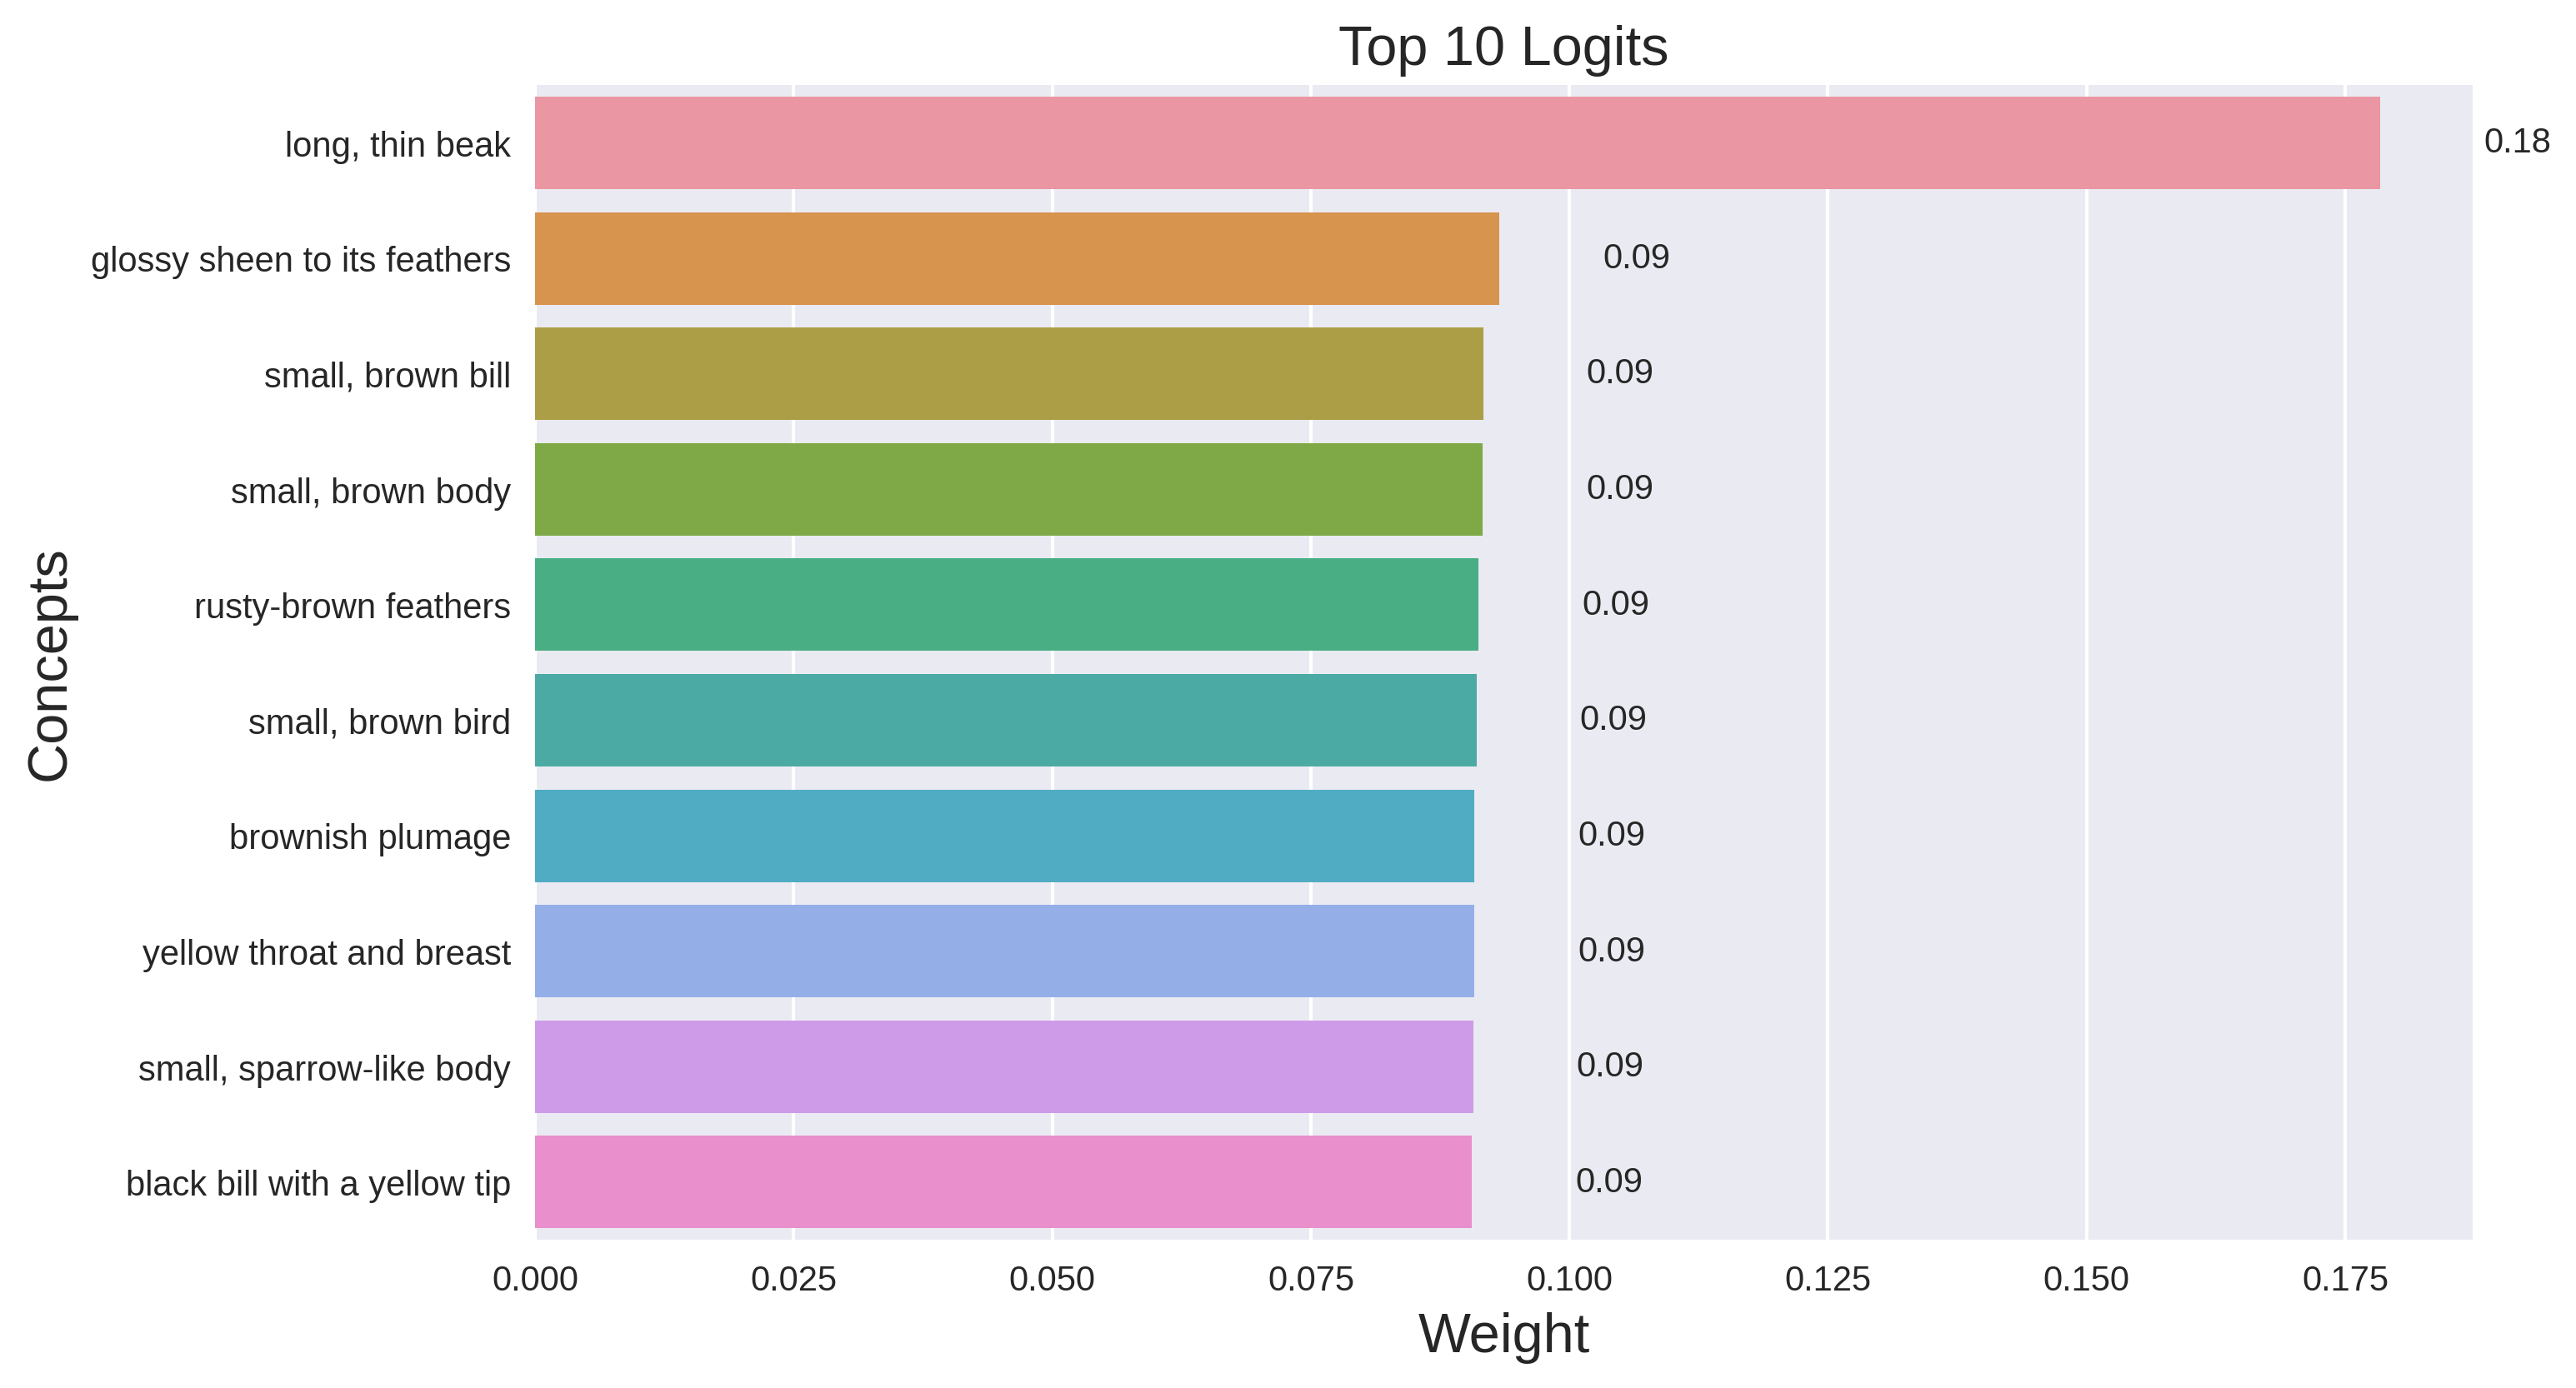

In [58]:
draw_bottleneck(image_2, probs, k=10, concepts=concepts, draw_probs=True)

In [59]:
altclip_trainer2.test()

Begin Testing


0it [00:00, ?it/s]

46.631944274902345 

46.085069274902345 

Finished Testing


### **ALIGN**

In [ ]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.align_link,
                                                 )

In [ ]:
val_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                               concepts=concepts,
                                               prep_loaders="val",
                                               batch_size=128,
                                               backbone_name=Constants.align_link,
                                              )

In [ ]:
test_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                                concepts=concepts,
                                                prep_loaders="test",
                                                batch_size=128,
                                                backbone_name=Constants.align_link,
                                               )

In [84]:
aling_config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="altclip_runs",
    net_types=["base", "base"],
    backbones=[Constants.align_link, Constants.align_link],
    displayed_names=["ALIGN, gumbel, 3e-4", "ALIGN, similarity, 3e-4"],
    training_methods=["gumbel", "similarity"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=[],
)

In [ ]:
align_trainer = BottleneckTrainer(
    aling_config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device,
    #report_to="wandb",
)

In [ ]:
align_trainer.train()

### CLIP LAION

**cub**

In [7]:
len(concepts)

370

In [8]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_laion_link,
                                                 )

  0%|          | 0/74 [00:00<?, ?it/s]

In [9]:
val_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                               concepts=concepts,
                                               prep_loaders="val",
                                               batch_size=128,
                                               backbone_name=Constants.clip_laion_link,
                                              )

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
test_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                                concepts=concepts,
                                                prep_loaders="test",
                                                batch_size=128,
                                                backbone_name=Constants.clip_laion_link,
                                               )

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
cliplaion_config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=10,
    run_name="clip_laion_runs",
    net_types=["base", "base"],
    backbones=[Constants.clip_laion_link, Constants.clip_laion_link],
    displayed_names=["CLIP-LAION, gumbel, 3e-4", "CLIP-LAION, l1, 3e-4", ],
    training_methods=["gumbel", "l1"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=[],
)

In [25]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Thu Mar 21 09:23:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 27%   28C    P8              21W / 250W |      3MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [26]:
!kill 152879

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


: 

In [24]:
cliplaion_trainer = BottleneckTrainer(
    cliplaion_config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device,
    #report_to="wandb",
)

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [22]:
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [72]:
print_trainable_parameters(cliplaion_trainer.nets[0])

trainable params: 140,600 || all params: 151,417,913 || trainable%: 0.09


In [23]:
cliplaion_trainer.train()


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
